# Test Script - Neural Net Regressor

## Loading Libraries

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

import pickle
import random
import time

# Importing Torch & SKORCH Models
from torch import nn
import torch

import skorch
from skorch import NeuralNetRegressor as SkorchNNR, NeuralNetClassifier as SkorchNNC
from skorch.callbacks import EarlyStopping

# Importing Neural Net Regressor
from nnr_custom import Torch_Model_BasicRegressor as bNNR

# Importing Bayesian Optimizer and Acquisition Functions
from modAL.models import BayesianOptimizer
from modAL.acquisition import max_EI, max_PI, max_UCB

# Importing Custom Acquisiton Functions and Decay Functions
from utils import StepWiseDecay as SWD
import utils

In [2]:
# parameters
fingerprint = 'morgan'
model = 'NNR'
file_name = "complete_file_morgan.feather"
config_file_name = 'NNR.json'
use_subset = True
use_unified_file = True
assay_limit = 300

## Loading Datasets

In [3]:
random.seed(42)
file_path = '/data_temp/default_{}/'.format(fingerprint)

try:
    if use_unified_file == True:
        try:
            df = pd.read_feather("../data" + file_path + file_name)
        except:
            df = pd.read_parquet("../data" + file_path + file_name)
        df_nan = pd.read_parquet("../data" + file_path + "assay_id/assay_id_null_file.parquet")
        df_assays = pd.read_parquet("../data" + file_path + "assay_id/assay_id_file.parquet")

    elif use_unified_file == False:
        df_fingerprint = pd.read_parquet("../" + file_path + "/fingerprint/{}_fingerprint_file.parquet".format(fingerprint))
        df = pd.read_parquet("../" + file_path + "/preprocessed/preprocessed_file.parquet")
        df_nan = pd.read_parquet("../" + file_path + "/assay_id/assay_id_null_file.parquet")
        df_assays = pd.read_parquet("../" + file_path + "/assay_id/assay_id_file.parquet")
    else:
        print("Incorrect value for 'use_unified_file' parameter passed. Please recheck.")
        pass
except:
    print("Data File not found")

Identifying noisy assays

In [4]:
df_nan.loc[df_nan['squared_pearson_trn'].isnull()]

,assay_id,squared_pearson_trn,squared_pearson_tst,assay_length_trn,assay_length_tst,assay_length_total
1,303216,NaN,NaN,45,15,60
2,303260,NaN,NaN,45,15,60
4,737235,NaN,NaN,45,15,60


Removing Noisy Assays

In [5]:
# df = df.drop(nan_assays)
for i in df_nan.loc[df_nan['squared_pearson_trn'].isnull()]['assay_id']:
    df = df.drop(labels = df.loc[df['assay_id']==i].index)
df.loc[df['assay_id']==303216].head()
print('x-----x-----x-----x')
df.loc[df['assay_id']==303260].head()
print('x-----x-----x-----x')
df.loc[df['assay_id']==737235].head()
print('x-----x-----x-----x')

x-----x-----x-----x
x-----x-----x-----x
x-----x-----x-----x


Loading Config Files

In [6]:
# Loading JSON config file
try:
    with open('../config/' + config_file_name) as f:
        params_config = json.load(f)
        print('JSON config file for {} successfully loaded'.format(model))
except FileNotFoundError:
    print('Config file for model {} is missing.Resorting to default params'.format(model))
    with open('../config/{}_default.json'.format(model)) as f:
        params_config = json.load(f)
try:
    with open('../config/decay_values.json') as f:
        decay_list = json.load(f)
        decay_list = decay_list["decay values"]
except:
    decay_list = [1.0,0.75,0.5,0.25,0.125,0.1,0.05]
    print('Config file for decay values is missing. Resorting to default values: {}'.format(decay_list))

if os.path.isdir('../models/{0}_{1}/'.format(model,fingerprint)) == False:
    os.mkdir('../models/{0}_{1}/'.format(model,fingerprint))

if os.path.isdir('../data/data_results/{0}_{1}/'.format(model,fingerprint)) == False:
    os.mkdir('../data/data_results/{0}_{1}/'.format(model,fingerprint))

if os.path.isdir('../data/data_results/{0}_{1}/plots'.format(model,fingerprint)) == False:
    os.mkdir('../data/data_results/{0}_{1}/plots'.format(model,fingerprint))

# Creating List of Classifiers
clfs = []
acquisition_list = []
clf_list = []
count = 0
clf_list_names = []

for neural_net in params_config["model"]:
    if neural_net == "BasicNNR()":
        clf_type = bNNR
    else:
        clf_type = bNNR
    clf = {
        "type" : clf_type,
        "name" : neural_net
    }
    clfs.append(clf)

for function in params_config["acquisition"]:
    if function=="max_EI":
        acquisition_type = max_EI
    elif function=="max_PI":
        acquisition_type = max_PI
    elif function=="max_UCB":
        acquisition_type = max_UCB
    elif function=="random":
        acquisition_type = utils.random_sampling
    elif function=="equivalent":
        acquisition_type = utils.equivalent_sampling
    elif function=="margin_entropy":
        acquisition_type = utils.margin_entropy_sampling
    elif function=="uncertainty_margin":
        acquisition_type = utils.uncertainty_margin_sampling
    elif function=="product_sampling":
        acquisition_type = utils.product_sampling
    else:
        acquisition_type = max_EI
    acquisition = {
        "type" : acquisition_type,
        "name": function
    }
    acquisition_list.append(acquisition)
if params_config["optimizer"] == "Adam":
    default_optimizer = torch.optim.Adam
    
for model_selected in clfs:
    for ac_func in acquisition_list:
        for lr in params_config["learning_rate"]:
            clf = {
                "model" :model_selected["type"],
                "model_name" : model_selected["name"],
                "acquisition_function" :ac_func["type"],
                "acquisition_function_name" : ac_func["name"],
                "learning_rate" : lr,
                "optimizer" : default_optimizer
            }
            clf_list.append(clf)
            clf_list_names.append("model_{}_{}_{}".format(clf["model_name"], clf["learning_rate"], clf["acquisition_function_name"]))

clf_list_names = ['assay_id','subset_size_trn','total_length'] + clf_list_names

num_iterations=params_config["iterations"]

JSON config file for NNR successfully loaded


Creating the dynamic Result Data Matrix to store the results

In [7]:
pearson_trn = [[0 for i in range(len(clf_list)+3)] for j in range(len(df["assay_id"].unique()+1))]
pearson_tst = [[0 for i in range(len(clf_list)+3)] for j in range(len(df["assay_id"].unique()+1))]

pearson_values_graph = [[0 for i in range(len(params_config["learning_rate"])*len(acquisition_list))] for j in range(num_iterations)]


Suppresing warnings

In [8]:
import warnings
warnings.simplefilter('ignore')

Initialising Early Stopping Criteria

In [9]:
torch.cuda.is_available()
earlystopping = EarlyStopping(monitor='valid_loss', patience=20,threshold=0.0001, threshold_mode='rel', lower_is_better=True)

## Training Cyle

In [10]:
list_subset_sizes = []
list_total_sizes = []
row = 0
column = 0
pvg_column = 0
pvg_row = 0

# Assay for which graphs have to be generated
# flag_first_assay = 688239
# flag_first_assay = 517
flag_first_assay = 70695

first_start = time.time()
try:
    # Intialising the Decay Function
    decay_tracker = SWD(decay_list)
    count = 0
    device = "cuda" if torch.cuda.is_available() else "cpu"

    for assay_id in df['assay_id'].unique():
        if assay_id == np.int64(flag_first_assay):
            print('Reached selected assay at time = {}'.format(time.time() - first_start))
        
        # Isolating the training and testing samples for the specfic assay
        df_current = df.loc[df['assay_id']==assay_id]
        df_train = df_current.loc[df['Clustering']=='TRN']
        df_tst = df_current.loc[df['Clustering']=='TST']
        column=0
        pvg_column = 0

        # Uncomment this snippet to generate model only for a single assay as specified by 'flag_first_assay'
        if assay_id != np.int64(flag_first_assay):
            continue

        # Initialising the length of the required subset as dictated by the Decay Function
        subset_size = int(decay_tracker.calculate(df_train.shape[0])*df_train.shape[0])
        list_subset_sizes.append(subset_size)
        list_total_sizes.append(df_train.shape[0])
        
        pearson_trn[row][column] = assay_id
        pearson_tst[row][column] = assay_id
        column+=1

        if use_subset == True:
            X = np.array(df_train.iloc[:,10:]).astype(np.float32)[:subset_size]
            y = np.array(df_train.iloc[:,3]).astype(np.float32)[:subset_size]
        else:
            X = np.array(df_train.iloc[:,10:]).astype(np.float32)
            y = np.array(df_train.iloc[:,3]).astype(np.float32)
        
        start = time.time()

        print("Subset selected in {}".format(time.time() - start))
        train_idx = np.random.choice(range(X.shape[0]), size=int(X.shape[0]*0.1), replace=False)

        x_initial = X[train_idx]
        y_initial = y[train_idx]

        X = np.delete(X,train_idx, axis=0)
        y = np.delete(y,train_idx)


        pearson_trn[row][column] = subset_size
        pearson_tst[row][column] = subset_size
        column+=1

        pearson_trn[row][column] = df_train.shape[0]
        pearson_tst[row][column] = df_tst.shape[0]
        column+=1

        
        if use_unified_file==True:
            for gpr_model in clf_list:

                # Training cycle for each model-acquistion function pairs
                if assay_id==np.int64(flag_first_assay):
                    print("Data is for model {} with acc_func {}".format(gpr_model["model_name"], gpr_model["acquisition_function_name"]))
                
                # Creating Skorch NNR object
                regressor = SkorchNNR(
                    gpr_model["model"],
                    lr=gpr_model["learning_rate"],
                    criterion= nn.MSELoss,
                    max_epochs = params_config["epochs"],
                    batch_size = 32,
                    train_split = skorch.dataset.ValidSplit(5) if int(X.shape[0]*0.1)>5 else skorch.dataset.ValidSplit(int(X.shape[0]*0.1)),
                    optimizer =gpr_model["optimizer"],
                    device = device,
                    callbacks = [earlystopping],
                    warm_start = True,
                    verbose = 1
                    )
                
                print("Before model creation : {}".format(time.time() - start))
                
                # Creating the BayesianOptimizer object with the initial values
                learner = BayesianOptimizer(
                    estimator=regressor,
                    query_strategy=gpr_model["acquisition_function"],
                    X_training=x_initial.reshape(x_initial.shape[0],-1), y_training=y_initial.reshape(-1,1)
                )

                print("After model creation and training {}".format(time.time() - start))
                pvg_row=0
                for n_query in range(num_iterations):
                    if assay_id==np.int64(flag_first_assay):
                        
                        print(pvg_row,pvg_column)
                        predictions_first_assay = learner.predict(np.array(df_train.iloc[:,10:].astype(np.float32)))
                        
                        print("The predicted values are {} and type is {} and shape is {}".format(predictions_first_assay, type(predictions_first_assay), predictions_first_assay.shape))
                        original_assay = np.array(df_train.iloc[:,3]).reshape(-1,).astype(np.float32)
                        
                        print("The type of the original array is {} and shape is {} ".format(type(original_assay),original_assay.shape))
                        print(type(predictions_first_assay),type(original_assay))      
                        pearson_values_graph[pvg_row][pvg_column] = round(np.corrcoef(original_assay, predictions_first_assay.reshape(-1,))[0,1]**2,5)
                        print("The pearson coefficient values are {}".format(pearson_values_graph[pvg_row][pvg_column]))
                            
                        pvg_row+=1
                    try:
                        # Querying samples from the the query space
                        query_idx,query_inst = learner.query(X, n_instances=10)
                    except AssertionError:
                        print("Encountered a case where the number of intances is lower than utility")
                           
                        # Teaching the Committee Object
                    learner.teach(X=query_inst,y=y[query_idx].reshape(-1,1))

                print('Training Process for acc func {} has been completed in '.format(gpr_model["acquisition_function_name"],time.time()-start))    
                
                # Saving the generated model
                with open('../models/{0}_{1}/{2}_{3}_{4}.pickle'.format(model,fingerprint,gpr_model["model_name"],gpr_model["acquisition_function_name"],flag_first_assay),'wb') as f:
                    pickle.dump(learner,f)
                
                # Loading the pre-generated model
                with open('../models/{0}_{1}/{2}_{3}_{4}.pickle'.format(model,fingerprint,gpr_model["model_name"],gpr_model["acquisition_function_name"],flag_first_assay),'rb') as f:
                     learner = pickle.load(f)
                
                # Predict model performance on the training samples
                predictions = learner.predict(np.array(df_train.iloc[:,10:]).astype(np.float32))
                result_trn = round(np.corrcoef(np.array(df_train.iloc[:,3]).reshape(-1,).astype(np.float32), predictions.reshape(-1,))[0,1]**2,5)

                # Predict model performance on the testing samples
                predictions = learner.predict(np.array(df_tst.iloc[:,10:]).astype(np.float32))
                result_tst = round(np.corrcoef(np.array(df_tst.iloc[:,3]).reshape(-1,).astype(np.float32), predictions.reshape(-1,))[0,1]**2,5)

                # Saving the model predictions in the Result Data Matrix
                pearson_trn[row][column] = result_trn
                pearson_tst[row][column] = result_tst
                
                column+=1
                pvg_column+=1
        else:
            print("Feature is in the works.")   
        row+=1
        count+=1
        print("Parsed {} assays".format(count))
        if count >= assay_limit:
                break
    print('Reached selected assay at time = {}'.format(time.time() - start))
    
except NameError:
    print('Key Error')

Reached selected assay at time = 54.8768572807312
Subset selected in 0.0
Data is for model BasicNNR() with acc_func random
Before model creation : 0.005002737045288086
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       72.7778       45.1644  5.9385
      2       72.4162       45.0287  0.0160
      3       72.1714       44.8666  0.0160
      4       71.8191       44.6843  0.0170
      5       71.4177       44.4966  0.0210
      6       71.0556       44.3041  0.0180
      7       70.6257       44.1070  0.0200
      8       70.2279       43.9056  0.0170
      9       69.7817       43.6996  0.0160
     10       69.3226       43.4885  0.0170
     11       68.8563       43.2719  0.0150
     12       68.3756       43.0494  0.0160
     13       67.9256       42.8205  0.0150
     14       67.3391       42.5847  0.0160
     15       66.8390       42.3411  0.0150
     16       66.2285       42.0893  0.0150
     17       65.6443       41.8280  0.0

Displaying the time taken for model creation

In [11]:
print('Reached selected assay at time = {}'.format(time.time() - start))

Reached selected assay at time = 793.7202475070953


Results of the selected assay

In [12]:
pearson_values_graph

[[0.30623, 0.31958, 0.31068],
 [0.36199, 0.10695, 0.13738],
 [0.36823, 0.33736, 0.17284],
 [0.46316, 0.42086, 0.4166],
 [0.52877, 0.4413, 0.4791],
 [0.54675, 0.43277, 0.48345],
 [0.58728, 0.43913, 0.48556],
 [0.60457, 0.4423, 0.48587],
 [0.60723, 0.4423, 0.48601],
 [0.61284, 0.44126, 0.48588],
 [0.61775, 0.44248, 0.48548],
 [0.61954, 0.44255, 0.48583],
 [0.61952, 0.44131, 0.48576],
 [0.61979, 0.44219, 0.48549],
 [0.62044, 0.44267, 0.48633],
 [0.62449, 0.44177, 0.48607],
 [0.62412, 0.44194, 0.4857],
 [0.62542, 0.44026, 0.48435],
 [0.6274, 0.44103, 0.48522],
 [0.62784, 0.44167, 0.48585],
 [0.64183, 0.4417, 0.48558],
 [0.66786, 0.4411, 0.48625],
 [0.67336, 0.44231, 0.48482],
 [0.67551, 0.44198, 0.48518],
 [0.67526, 0.44165, 0.4854]]

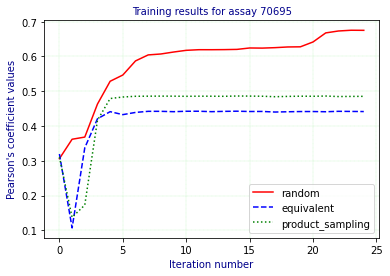

In [13]:
pd.DataFrame(pearson_trn, columns=clf_list_names).to_csv('../data/data_results/{0}_{1}/pearsons_training_set_{2}.csv'.format(model,fingerprint,num_iterations),index=False)
pd.DataFrame(pearson_tst, columns=clf_list_names).to_csv('../data/data_results/{0}_{1}/pearsons_test_set_{2}.csv'.format(model,fingerprint,num_iterations),index=False)

pearson_values_graph = pd.DataFrame(pearson_values_graph, columns=params_config["acquisition"])
pearson_values_graph.to_csv('../data/data_results/{0}_{1}/squared_pearson_{2}.csv'.format(model,fingerprint,flag_first_assay),index=False)

colours = ['-r','--b',':g','^y','-.k','.c','om','xk']
colour_count = 0
font_custom = {
    "family" : "sans-serif",
    "color" : "darkblue",
    "size" : "10"
    }

plt.title("Training results for assay {}".format(flag_first_assay), fontdict=font_custom, loc='center')
plt.xlabel("Iteration number", fontdict=font_custom)
plt.ylabel("Pearson's coefficient values", fontdict=font_custom)


for (column_name,column_contents) in pearson_values_graph.iteritems():
    plt.plot([x for x in range(len(column_contents))],column_contents, colours[colour_count], label='{}'.format(column_name))
    colour_count +=1
plt.grid(color = 'lightgreen', linestyle = '--', linewidth =0.25)
plt.legend()
plt.savefig('../data/data_results/{0}_{1}/plots/training_cycles_{2}.jpg'.format(model,fingerprint,flag_first_assay),
                format='jpg',
               )
plt.show()